### Initialize Notebook

In [ ]:
%pip install requests
%pip install pandas
%pip install matplotlib
%pip install openai
%pip install python-dotenv

In [14]:
import os
import dotenv
import json
import requests

dotenv.load_dotenv()

resource_group = os.getenv("RESOURCE_GROUP")
subscription_id = os.getenv("SUBSCRIPTION_ID")
apim_eus_resource_url = os.getenv("APIM_EUS_RESOURCE_URL")
apim_wus_resource_url = os.getenv("APIM_WUS_RESOURCE_URL")
apim_subscription_key = os.getenv("APIM_SUBSCRIPTION_KEY")
openai_deployment_name = os.getenv("OPENAI_DEPLOYMENT_NAME")
openai_model_name = os.getenv("OPENAI_MODEL_NAME")
openai_api_version = os.getenv("OPENAI_API_VERSION")
app_insights_app_id = os.getenv("APP_INSIGHTS_APP_ID")

### Token Limit Policy

1. Test API Token

In [15]:
url = apim_eus_resource_url + "/openai/deployments/" + openai_deployment_name + "/chat/completions?api-version=" + openai_api_version
api_runs = []
for i in range(10):
    messages={"messages":[
        {"role": "system", "content": "You are an intelligent assistant."},
        {"role": "user", "content": "Can you tell me a long winded fact?"}
    ]}
    response = requests.post(url, headers = {'api-key':apim_subscription_key}, json = messages)
    if (response.status_code == 200):
        print("▶️ Run: ", i+1, "status code: ", response.status_code, "✅")
        data = json.loads(response.text)
        total_tokens = data.get("usage").get("total_tokens")
        print("💬 ", data.get("choices")[0].get("message").get("content"))
    else:
        print("▶️ Run: ", i+1, "status code: ", response.status_code, "⛔")
        print(response.text)
        total_tokens = 0
    api_runs.append((total_tokens, response.status_code))


▶️ Run:  1 status code:  200 ✅
💬  Certainly! Did you know that the process of photosynthesis is a complex and wondrous biochemical phenomenon that has been fundamental to life on Earth for billions of years? This process, primarily occurring in the chloroplasts of plant cells, involves the absorption of light energy by chlorophyll pigments. This light energy is then used to convert carbon dioxide from the atmosphere and water from the soil into glucose and oxygen. 

Specifically, photosynthesis consists of two major stages: the light-dependent reactions and the Calvin cycle. In the light-dependent reactions, which take place in the thylakoid membranes, sunlight is absorbed by chlorophyll and other accessory pigments. This absorbed light excites electrons to a higher energy state, which then travel through an electron transport chain, resulting in the production of ATP (adenosine triphosphate) and NADPH (nicotinamide adenine dinucleotide phosphate hydrogen). These molecules are crucial 

2. Analyze results

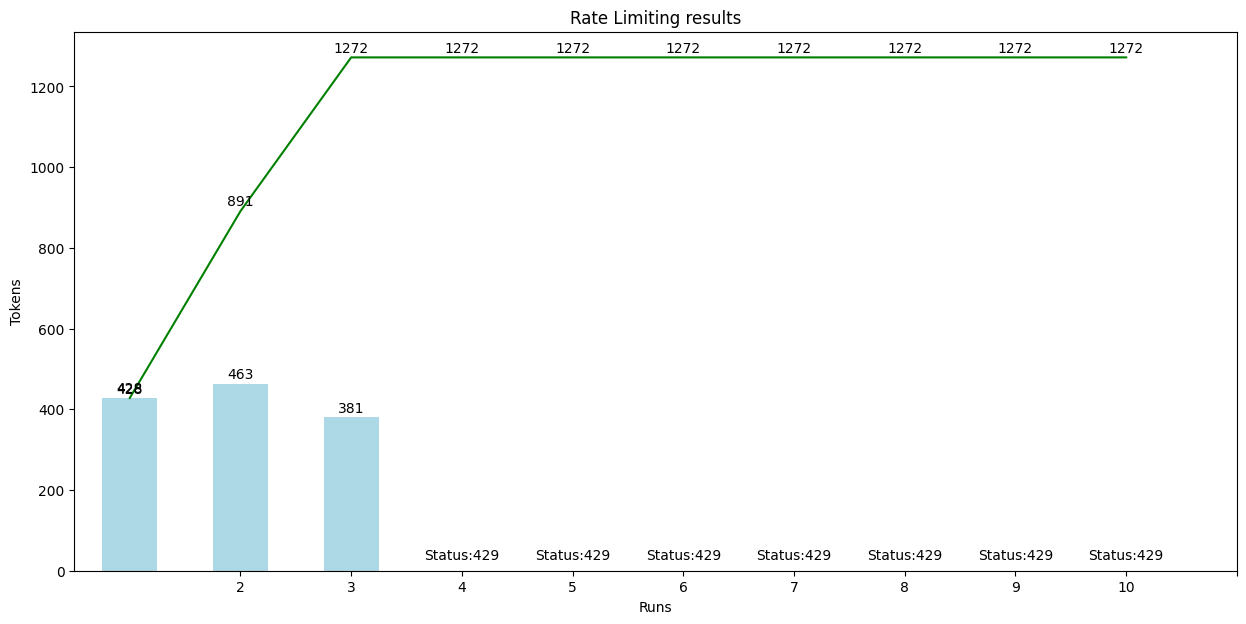

In [16]:
# plot the results
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams['figure.figsize'] = [15, 7]
df = pd.DataFrame(api_runs, columns=['Tokens', 'Status Code'])
df['Run'] = range(1, len(df) + 1)
colors = ['red' if str(code).startswith('5') else 'yellow' if str(code).startswith('4') else 'lightblue' for code in df['Status Code']]
ax = df.plot(kind='bar', x='Run', y='Tokens', color=colors, legend=False)
plt.title('Rate Limiting results')
plt.xlabel('Runs')
plt.ylabel('Tokens')
plt.xticks(df['Run'], rotation=0)
for i, val in enumerate(df['Status Code']):
    ax.text(i, 20, '' if int(val) == 200 else 'Status:429', ha='center', va='bottom')
for i, val in enumerate(df['Tokens']):
    ax.text(i, df['Tokens'][i] + 5, '' if int(val) == 0 else int(val), ha='center', va='bottom')
accumulated_tokens = df['Tokens'].cumsum()
ax.plot(df['Run']-1, accumulated_tokens, color='green', label='Accumulated Tokens')
for i, val in enumerate(accumulated_tokens):
    ax.text(i, val + 6, int(val), ha='center', va='bottom', label='Accumulated Tokens')
plt.show()

### 🔍 Token Emit Policy - App Insights

<a id='plot'></a> 
### 🔍 Load Balancing & Circuit breaking

LB Types
1. Round Robin
2. Weighted
3. Priority

In [13]:
! az deployment group create --resource-group {resource_group} --template-file "infrastructure/lb-ai-gateway.bicep"

/Users/jimmyshah/workspace/azure-ai-notebooks/infrastructure/lb-ai-gateway.bicep(71,3) : Warning BCP035: The specified "object" declaration is missing the following required properties: "protocol", "url". If this is an inaccuracy in the documentation, please report it to the Bicep Team. [https://aka.ms/bicep-type-issues]

{- Finished .. - Starting ..
  "id": "/subscriptions/c72983e8-50a6-45fe-a344-c897e45e10a7/resourceGroups/rg-cc-interac-demo/providers/Microsoft.Resources/deployments/lb-ai-gateway",
  "location": null,
  "name": "lb-ai-gateway",
  "properties": {
    "correlationId": "772d1cc8-6d2e-4ddb-ba19-3e167aafce61",
    "debugSetting": null,
    "dependencies": [
      {
        "dependsOn": [
          {
            "id": "/subscriptions/c72983e8-50a6-45fe-a344-c897e45e10a7/resourceGroups/rg-cc-interac-demo/providers/Microsoft.ApiManagement/service/apim-js-genai-gateway-demo",
            "resourceGroup": "rg-cc-interac-demo",
            "resourceName": "apim-js-genai-gateway

-- Test Load Balancing

<a id='plot'></a>
### 🔍 Analyze Semantic Caching Testing

In [17]:
sc_endpoint = os.environ["SC_ENDPOINT"]
sc_api_key = os.environ["SC_API_KEY"]
sc_api_version = os.environ["SC_API_VERSION"]
sc_openai_deployment_name = os.environ["SC_OPENAI_DEPLOYMENT_NAME"]
sc_openai_model_name = os.environ["SC_OPENAI_MODEL_NAME"]
sc_subscription = os.environ["SC_SUBSCRIPTION"]

In [18]:
!az account set --subscription {sc_subscription}

In [19]:
from openai import AzureOpenAI
import time, random

runs = 10
questions = ["Provide a short fact", 
             "Tell me a short story", 
             "What is the meaning of life",]
api_runs = [] 
for i in range(runs):
    random_question = random.choice(questions)
    messages=[
        {"role": "system", "content": "You are a insightful assistant."},
        {"role": "user", "content": random_question}
    ]
    client = AzureOpenAI(azure_endpoint=sc_endpoint, api_key=sc_api_key, api_version=sc_api_version)
    start_time = time.time()
    response = client.chat.completions.create(model=sc_openai_model_name, messages=messages)
    response_time = time.time() - start_time
    print("▶️ Run: ", i+1, f"duration: {response_time:.2f} seconds")
    print("💬 ", random_question, " ----> ", response.choices[0].message.content)
    api_runs.append(response_time)

▶️ Run:  1 duration: 20.06 seconds
💬  Tell me a short story  ---->  Once upon a time in a small village nestled deep in the mountains, there was a young girl named Lily. Lily had always been captivated by the beauty of nature and would spend her days exploring the lush forests and serene meadows that surrounded her home.

One sunny day, as Lily ventured deeper into the woods, she stumbled upon an old, overgrown path that led to a hidden glen. Intrigued, she followed the path until she reached a small clearing filled with colorful wildflowers and a gentle stream flowing through it.

As she sat on a mossy rock by the stream, Lily noticed something sparkling in the water. Upon closer inspection, she realized it was a beautiful, intricately designed crystal pendant. Unable to resist its allure, she reached down and picked it up, feeling a tingling sensation shoot through her fingertips.

Little did Lily know that the pendant possessed magical qualities. It had the power to grant wishes, bu

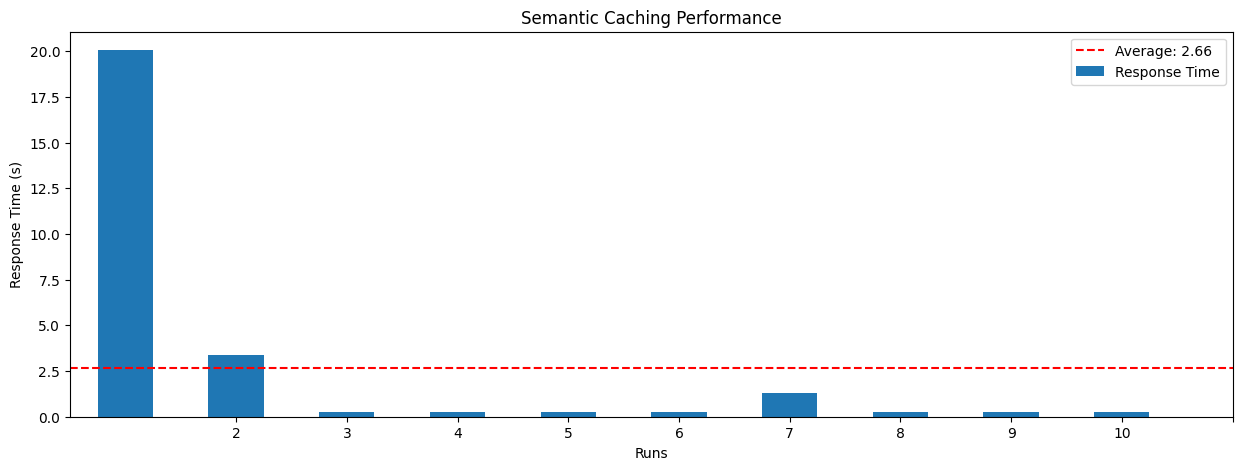

In [20]:
# plot the results
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams['figure.figsize'] = [15, 5]
df = pd.DataFrame(api_runs, columns=['Response Time'])
df['Run'] = range(1, len(df) + 1)
df.plot(kind='bar', x='Run', y='Response Time', legend=False)
plt.title('Semantic Caching Performance')
plt.xlabel('Runs')
plt.ylabel('Response Time (s)')
plt.xticks(df['Run'], rotation=0)  # Set x-axis ticks to be the run numbers

average = df['Response Time'].mean()
plt.axhline(y=average, color='r', linestyle='--', label=f'Average: {average:.2f}')
plt.legend()

plt.show()